In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install torchinfo

In [3]:
from torchvision import models
from torchinfo import summary


model = models.alexnet(weights="AlexNet_Weights.IMAGENET1K_V1")
summary(model, (1, 3, 224, 224), device="cpu")

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 52.3MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [4]:
with open("/content/imagenet_classes.txt", "r") as file:
    classes = file.read().splitlines()

print(f"클래스 개수 : {len(classes)}")
print(f"첫 번째 클래스 레이블 : {classes[0]}")

클래스 개수 : 1000
첫 번째 클래스 레이블 : tench


In [5]:
import torch
from PIL import Image
from torchvision import models, transforms

#AlexNet: introduced in 2012
#convolutional neural network(CNN), error rate was reduced from 26% to 16%
#AlexNet uses 1.) convolution, max pooling to extract image characteristics and
#2.) classify their class using a fully connected layer at the end
#AlexNet's structure p.456, 457
#Compared to LeNet-5, AlexNet has more convolutional layer, max pooling, fully comnnected layer
#LeNet-5 used rescaled logistic sigmoid function but AlexNet uses ReLU for activation function
#RELU prevents vanishing gradient problem


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

device = "cuda" if torch.cuda.is_available() else "cpu"
#import AlexNet
model = models.alexnet(weights="AlexNet_Weights.IMAGENET1K_V1").eval().to(device)

tensors = []
files = ["/content/airplane.jpg", "/content/dog.jpg"]
for file in files:
    image = Image.open(file)
    tensors.append(transform(image))

tensors = torch.stack(tensors)
print(f"입력 텐서의 크기 : {tensors.shape}")

입력 텐서의 크기 : torch.Size([2, 3, 224, 224])


In [6]:
import numpy as np
from torch.nn import functional as F

#model inference (p.465)
#we are not tracking the gradient, reduces memory usage, faster computation speed

#softmax: multi-classification
#sigmoid: binary classification
#LeNet-5 uses sigmoid function instead of softmax

with torch.no_grad():
    outputs = model(tensors.to(device))
    probs = F.softmax(outputs, dim=-1)
    top_probs, top_idxs = probs.topk(5)

top_probs = top_probs.detach().cpu().numpy()
top_idxs = top_idxs.detach().cpu().numpy()
top_classes = np.array(classes)[top_idxs]

for idx, (cls, prob) in enumerate(zip(top_classes, top_probs)):
    print(f"{files[idx]} 추론 결과")
    for c, p in zip(cls, prob):
        print(f" - {c:<30} : {p * 100:>5.2f}%")

/content/airplane.jpg 추론 결과
 - airliner                       : 66.83%
 - warplane                       : 20.12%
 - wing                           :  9.29%
 - space shuttle                  :  2.89%
 - missile                        :  0.38%
/content/dog.jpg 추론 결과
 - Doberman                       : 36.27%
 - toy terrier                    : 21.78%
 - miniature pinscher             : 11.68%
 - Appenzeller                    :  9.65%
 - Rottweiler                     :  4.59%


In [2]:
!unzip /content/drive/MyDrive/CV_study/pet.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/cat/cat.3703.jpg  
  inflating: train/cat/cat.3704.jpg  
  inflating: train/cat/cat.3705.jpg  
  inflating: train/cat/cat.3706.jpg  
  inflating: train/cat/cat.3707.jpg  
  inflating: train/cat/cat.3708.jpg  
  inflating: train/cat/cat.3709.jpg  
  inflating: train/cat/cat.371.jpg   
  inflating: train/cat/cat.3710.jpg  
  inflating: train/cat/cat.3711.jpg  
  inflating: train/cat/cat.3712.jpg  
  inflating: train/cat/cat.3713.jpg  
  inflating: train/cat/cat.3714.jpg  
  inflating: train/cat/cat.3715.jpg  
  inflating: train/cat/cat.3716.jpg  
  inflating: train/cat/cat.3717.jpg  
  inflating: train/cat/cat.3718.jpg  
  inflating: train/cat/cat.3719.jpg  
  inflating: train/cat/cat.372.jpg   
  inflating: train/cat/cat.3720.jpg  
  inflating: train/cat/cat.3721.jpg  
  inflating: train/cat/cat.3722.jpg  
  inflating: train/cat/cat.3723.jpg  
  inflating: train/cat/cat.3724.jpg  
  inflating: train/cat/cat.3725.jpg  
  inflating: t

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

hyperparams = {
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[1.0/255.0, 1.0/255.0, 1.0/255.0]
            )
        ]
    )
}

train_dataset = ImageFolder("/content/test", transform=hyperparams["transform"])
test_dataset = ImageFolder("/content/train", transform=hyperparams["transform"])

train_dataloader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)

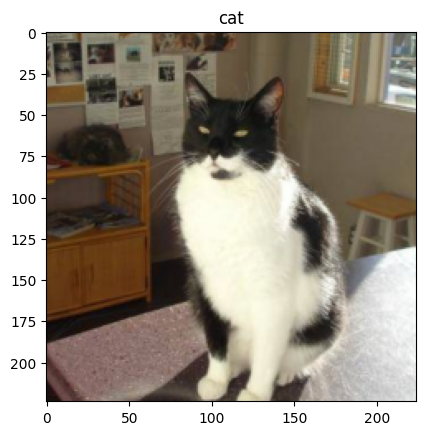

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

mean=[0.48235, 0.45882, 0.40784]
std=[1.0/255.0, 1.0/255.0, 1.0/255.0]

images, labels = next(iter(train_dataloader))
for image, label in zip(images, labels):
    image = image.numpy().transpose((1, 2, 0))
    image = ((std * image + mean) * 255).astype(np.uint8)

    plt.imshow(image)
    plt.title(train_dataset.classes[int(label)])
    plt.show()
    break
    #demonstration of the train dataset

In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder


hyperparams = {
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[1.0 / 255.0, 1.0 / 255.0, 1.0 / 255.0],
            ),
        ]
    ),
}

In [3]:
train_dataset = ImageFolder("/content/train", transform=hyperparams["transform"])
test_dataset = ImageFolder("/content/test", transform=hyperparams["transform"])

train_dataloader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)

In [5]:
model = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")
model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))

#VGG-16, introduced in 2014
#used for image detection, it is a convolution model as well (=like AlexNet)
#VGG-16 uses more convolutional layers + more max pooling -> has a better model inference than AlexNet
#example: VGG uses 3x3 filters many times while AlexNet uses 7x7 filter once (p.468)
#error rate for VGG-16 is 7% (AlexNet was 16%)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 181MB/s]


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])

#Cross Entropy Loss -> used to classify between two categories such as a dog or a cat
#SGD: stochastic gradient descent

In [7]:
#model training using back propagation
for epoch in range(hyperparams["epochs"]):
    cost = 0.0

    for images, classes in train_dataloader:
        images = images.to(device)
        classes = classes.to(device)

        output = model(images)
        loss = criterion(output, classes)

        optimizer.zero_grad() #once the training is over, the gradient should always become 0
        loss.backward() #back propagation
        optimizer.step()

        cost += loss

    cost = cost / len(train_dataloader)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")
    #the cost is decreasing = model is learning correctly

Epoch :    1, Cost : 0.291
Epoch :    2, Cost : 0.093
Epoch :    3, Cost : 0.066
Epoch :    4, Cost : 0.043
Epoch :    5, Cost : 0.035


In [8]:
#model inference
with torch.no_grad():
    model.eval()

    accuracy = 0.0
    for images, classes in test_dataloader:
        images = images.to(device)
        classes = classes.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=-1)
        outputs_classes = torch.argmax(probs, dim=-1)

        accuracy += int(torch.eq(classes, outputs_classes).sum())

    print(f"acc@1 : {accuracy / (len(test_dataloader) * hyperparams['batch_size']) * 100:.2f}%")
    #acc@1 measures the accuracy between the classes and the outputs_classes

acc@1 : 98.07%


In [9]:
torch.save(model.state_dict(), "/content/models/VGG16.pt")
print("Saved the model weights")

Saved the model weights


In [ ]:
from torch import nn


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [8]:
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion*planes,
            kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [9]:
import torch


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()

        self.inplanes = 64
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1)
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2)
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(num_blocks - 1):
            layers.append(block(self.inplanes, planes, 1))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [10]:
!pip install torchinfo

In [12]:
from torchvision import models
from torchinfo import summary


resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], 1000)
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 1000)
resnet50 = ResNet(BottleneckBlock, [3, 4, 6, 3], 1000)
resnet101 = ResNet(BottleneckBlock, [3, 4, 23, 3], 1000)
resnet152 = ResNet(BottleneckBlock, [3, 8, 36, 3], 1000)

torch_model = models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1").to("cpu")

resnet34_info = summary(resnet34, (1, 3, 224, 224), verbose=0)
torch_model_info = summary(torch_model, (1, 3, 224, 224), verbose=0)

print(resnet34_info.total_params)
print(torch_model_info.total_params)

21797672
21797672
